In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from funcs.models import model_ND
from funcs.fitting import loss
from scipy.optimize import minimize

## Heat input function

In [71]:
func_Q_in = lambda x: (1 + 0.5*np.sin(2*np.pi*x/(3600*12))) #

We are able to recover the desired heat capacity, thermal conductivity and initial temperature even with pretty bad intial guesses. However, need to ensure intial guesses are at least on the right order of magnitude.

## 2 Segments

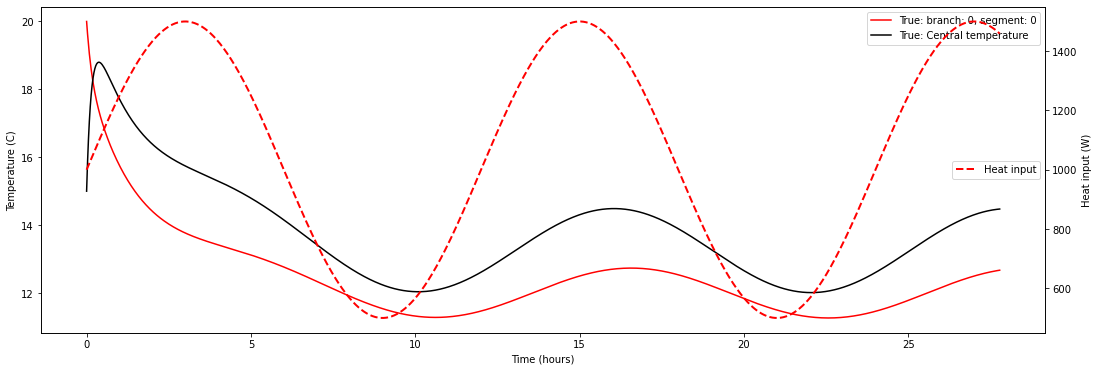

In [72]:
k = [800.0, 500.0]
c = [6e5, 2.5e6]
T = [15.0, 20.0]
true_params = np.array([*k, *c, *T])
T_out = 10
heatinput = 1000
iterations = 1000
# Initialise class with system parameters
sys_nd = model_ND('True', k, c, T, T_out, heatinput)

# Run simulation. This recreates simple_model.ipynb showing that our generalised model works.
times = np.linspace(0, 10e4, iterations+1)
Ts_true, Qs = sys_nd.run(times=times, func_Q_in=func_Q_in)
fig, ax = sys_nd.plot()

In [73]:
# Initial guesses for scipy.optimize.minimize
k0 = [900.0, 400.0]
c0 = [7e5, 1e6]
T0 = [16.0, 19.0]
initial_params = np.array([*k0, *c0, *T0])

### Fit to entire data

	Initial			Estimated		Actual
k1:	900.00000		901.78797		800.00000
k2:	400.00000		427.81427		500.00000
c1:	700000.00000		700000.00372		600000.00000
c2:	1000000.00000		1000000.00411		2500000.00000
T1:	16.00000		16.72519		15.00000
T2:	19.00000		23.86830		20.00000
______________________________________________________
Percentage error:
k1:		12.72%		k2:		14.44%
c1:		16.67%		c2:		60.00%
T1_initial:	11.50%		T2_initial:	19.34%


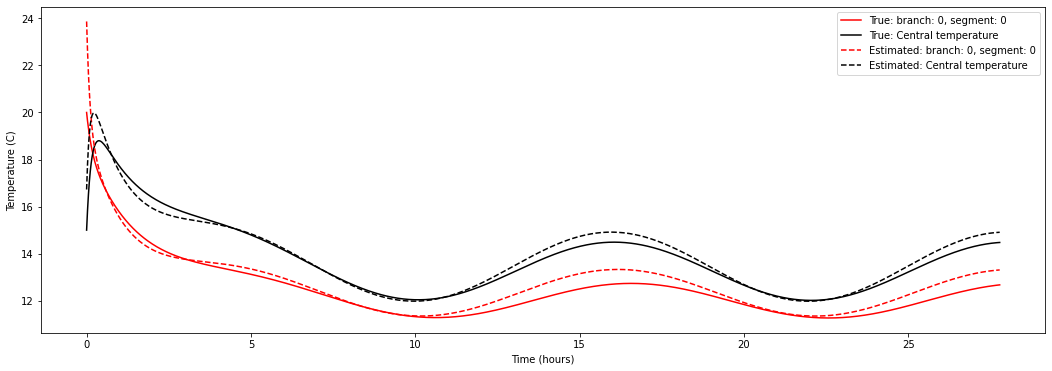

In [74]:
result = minimize(loss, x0=initial_params, tol=1e-3, args=('mse', times, Ts_true), bounds=((1e2,1e3),(1e2,1e3),(1e5,1e6),(1e6,3e6),(10,30),(10,30)))
k_est, c_est, T_est = result['x'].reshape((3,2))
sys_est = model_ND('Estimated',k_est, c_est, T_est, T_out, heatinput)
Ts_est, Qs = sys_est.run(times=times, func_Q_in=func_Q_in)

fig, ax = sys_nd.plot(show_heating=False)
fig, ax= sys_est.plot(figax=(fig, ax), show_heating=False, ls='--')

frac_error = abs((result['x'] - true_params)/true_params * 100)
print('\tInitial\t\t\tEstimated\t\tActual\nk1:\t{:.5f}\t\t{:.5f}\t\t{:.5f}\nk2:\t{:.5f}\t\t{:.5f}\t\t{:.5f}\nc1:\t{:.5f}\t\t{:.5f}\t\t{:.5f}\nc2:\t{:.5f}\t\t{:.5f}\t\t{:.5f}\nT1:\t{:.5f}\t\t{:.5f}\t\t{:.5f}\nT2:\t{:.5f}\t\t{:.5f}\t\t{:.5f}'.format(*np.ravel([initial_params,result['x'],true_params],'F')))
print('_'*54)
print('Percentage error:\nk1:\t\t{:.2f}%\t\tk2:\t\t{:.2f}%\nc1:\t\t{:.2f}%\t\tc2:\t\t{:.2f}%\nT1_initial:\t{:.2f}%\t\tT2_initial:\t{:.2f}%'.format(*frac_error))

### Fit to first 80%, test loss on final 20%
> Note that blue shaded region shows performance of model on unseen data

In [75]:
idxs = 4*iterations//5

	Initial			Estimated		Actual
k1:	900.00000		900.08833		800.00000
k2:	400.00000		401.35721		500.00000
c1:	700000.00000		700000.00025		600000.00000
c2:	1000000.00000		1000000.00053		2500000.00000
T1:	16.00000		16.46701		15.00000
T2:	19.00000		23.51049		20.00000
______________________________________________________
Percentage error:
k1:		12.51%		k2:		19.73%
c1:		16.67%		c2:		60.00%
T1_initial:	9.78%		T2_initial:	17.55%


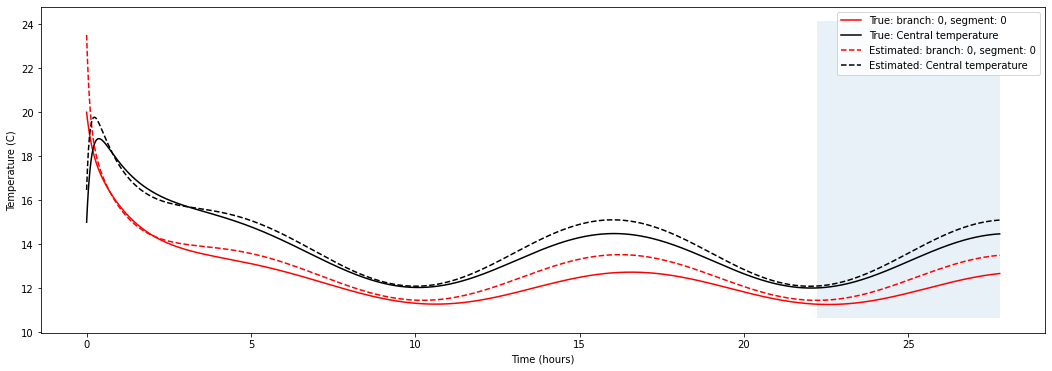

In [76]:
result = minimize(loss, x0=initial_params, tol=1e-3, args=('mse', times[:idxs], Ts_true[:,:,:idxs]), bounds=((1e2,1e3),(1e2,1e3),(1e5,1e6),(1e6,3e6),(10,30),(10,30)))
k_est, c_est, T_est = result['x'].reshape((3,2))
sys_est = model_ND('Estimated',k_est, c_est, T_est, T_out, heatinput)
Ts_est, Qs = sys_est.run(times=times, func_Q_in=func_Q_in)

fig, ax = sys_nd.plot(show_heating=False)
fig, ax= sys_est.plot(figax=(fig, ax), show_heating=False, ls='--')
ax.fill_between(times[idxs:]/3600, *ax.get_ylim(), alpha=0.1)

frac_error = abs((result['x'] - true_params)/true_params * 100)
print('\tInitial\t\t\tEstimated\t\tActual\nk1:\t{:.5f}\t\t{:.5f}\t\t{:.5f}\nk2:\t{:.5f}\t\t{:.5f}\t\t{:.5f}\nc1:\t{:.5f}\t\t{:.5f}\t\t{:.5f}\nc2:\t{:.5f}\t\t{:.5f}\t\t{:.5f}\nT1:\t{:.5f}\t\t{:.5f}\t\t{:.5f}\nT2:\t{:.5f}\t\t{:.5f}\t\t{:.5f}'.format(*np.ravel([initial_params,result['x'],true_params],'F')))
print('_'*54)
print('Percentage error:\nk1:\t\t{:.2f}%\t\tk2:\t\t{:.2f}%\nc1:\t\t{:.2f}%\t\tc2:\t\t{:.2f}%\nT1_initial:\t{:.2f}%\t\tT2_initial:\t{:.2f}%'.format(*frac_error))

### Fit to first 20%, test loss on final 80%
> Note that blue shaded region shows performance of model on unseen data

In [77]:
idxs = 1*iterations//5

	Initial			Estimated		Actual
k1:	900.00000		889.11722		800.00000
k2:	400.00000		302.19612		500.00000
c1:	700000.00000		700000.01115		600000.00000
c2:	1000000.00000		1000000.01162		2500000.00000
T1:	16.00000		15.62626		15.00000
T2:	19.00000		21.52746		20.00000
______________________________________________________
Percentage error:
k1:		11.14%		k2:		39.56%
c1:		16.67%		c2:		60.00%
T1_initial:	4.18%		T2_initial:	7.64%


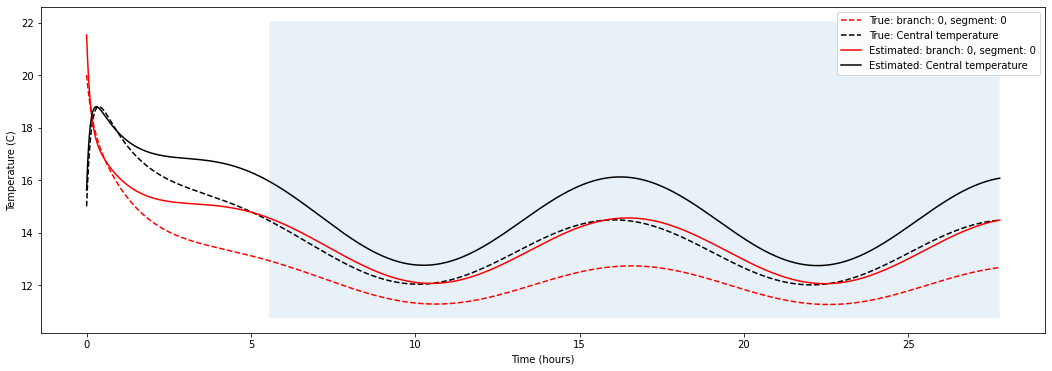

In [78]:
result = minimize(loss, x0=initial_params, tol=1e-3, args=('mse', times[:idxs], Ts_true[:,:,:idxs]), bounds=((1e2,1e3),(1e2,1e3),(1e5,1e6),(1e6,3e6),(10,30),(10,30)))
k_est, c_est, T_est = result['x'].reshape((3,2))
sys_est = model_ND('Estimated',k_est, c_est, T_est, T_out, heatinput)
Ts_est, Qs = sys_est.run(times=times, func_Q_in=func_Q_in)

fig, ax = sys_nd.plot(ls='--', show_heating=False)
fig, ax= sys_est.plot(figax=(fig, ax), show_heating=False)
ax.fill_between(times[idxs:]/3600, *ax.get_ylim(), alpha=0.1)

frac_error = abs((result['x'] - true_params)/true_params * 100)
print('\tInitial\t\t\tEstimated\t\tActual\nk1:\t{:.5f}\t\t{:.5f}\t\t{:.5f}\nk2:\t{:.5f}\t\t{:.5f}\t\t{:.5f}\nc1:\t{:.5f}\t\t{:.5f}\t\t{:.5f}\nc2:\t{:.5f}\t\t{:.5f}\t\t{:.5f}\nT1:\t{:.5f}\t\t{:.5f}\t\t{:.5f}\nT2:\t{:.5f}\t\t{:.5f}\t\t{:.5f}'.format(*np.ravel([initial_params,result['x'],true_params],'F')))
print('_'*54)
print('Percentage error:\nk1:\t\t{:.2f}%\t\tk2:\t\t{:.2f}%\nc1:\t\t{:.2f}%\t\tc2:\t\t{:.2f}%\nT1_initial:\t{:.2f}%\t\tT2_initial:\t{:.2f}%'.format(*frac_error))

### Looking at error as a function of test/train split:

In [79]:
splits = np.array([0.05, 0.1, 0.2, 0.3, 0.4, 0.6, 0.8, 0.9])
idxs = (splits*iterations).astype('int')
frac_errors = []
for idx in idxs:
    result = minimize(loss, x0=initial_params, tol=1e-3, args=('mse', times[:idx], Ts_true[:,:,:idx]), bounds=((1e2,1e3),(1e2,1e3),(1e5,1e6),(1e6,3e6),(10,30),(10,30)))
    k_est, c_est, T_est = result['x'].reshape((3,2))
    frac_error = abs((result['x'] - true_params)/true_params * 100) 
    frac_errors.append(frac_error)

In [80]:
frac_errors = np.array(frac_errors)

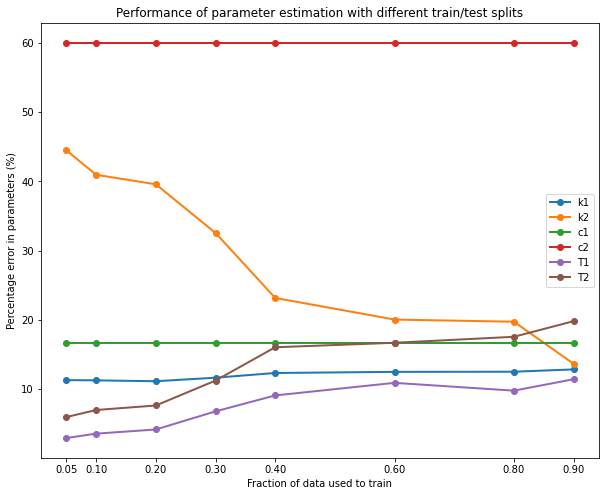

In [81]:
fig, ax = plt.subplots(1,1, figsize=(10,8))
ax.plot(splits, frac_errors, lw=2, marker='o');
ax.legend(['k1','k2','c1','c2','T1','T2'])
ax.set_xticks(splits)
ax.set(xlabel='Fraction of data used to train', ylabel='Percentage error in parameters (%)', title='Performance of parameter estimation with different train/test splits');